In [1]:
""" importamos libreriaS """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Objetivo

Crear variables a partir de los datos de serie de tiempo para utilizarlos en predicciones con redes neuronales

In [2]:
link = 'https://raw.githubusercontent.com/OrlandoBelli/OBH/master/time%20series.txt'

In [3]:
df = pd.read_csv(link)

df = pd.read_csv(link, sep=',', parse_dates=[0], header = None,index_col=0, names = ['fecha','unidades'])
df.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


In [4]:
# selecciono features

df = df.loc[:,['unidades']]
df.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


Plot de las variables en el tiempo ("fecha")

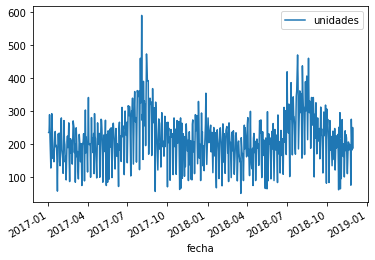

In [5]:
df.plot()

In [6]:
melt = df.copy()

In [7]:
melt.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


# Escalamiento

In [8]:
# escalando las variables

from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler()
melt = pd.DataFrame(scaler.fit_transform(melt))

In [9]:
melt.columns=['unidades']
melt.head()

,unidades
0,0.342593
1,0.344444
2,0.442593
3,0.314815
4,0.142593


# generamos predictores

In [10]:
# vf : valor futuro
melt['vf'] = melt['unidades'].shift(-1)
melt['vf2'] = melt['unidades'].shift(-2)
melt['vf3'] = melt['unidades'].shift(-3)
melt['vf4'] = melt['unidades'].shift(-4)
melt['vf5'] = melt['unidades'].shift(-5)
melt['vf6'] = melt['unidades'].shift(-6)
melt['vf7'] = melt['unidades'].shift(-7)
melt.head()

,unidades,vf,vf2,vf3,vf4,vf5,vf6,vf7
0,0.342593,0.344444,0.442593,0.314815,0.142593,0.448148,0.387037,0.283333
1,0.344444,0.442593,0.314815,0.142593,0.448148,0.387037,0.283333,0.196296
2,0.442593,0.314815,0.142593,0.448148,0.387037,0.283333,0.196296,0.238889
3,0.314815,0.142593,0.448148,0.387037,0.283333,0.196296,0.238889,0.177778
4,0.142593,0.448148,0.387037,0.283333,0.196296,0.238889,0.177778,0.327778


In [11]:
melt.tail()

,unidades,vf,vf2,vf3,vf4,vf5,vf6,vf7
599,0.416667,0.312963,0.244444,0.370370,0.255556,NaN,NaN,NaN
600,0.312963,0.244444,0.370370,0.255556,NaN,NaN,NaN,NaN
601,0.244444,0.370370,0.255556,NaN,NaN,NaN,NaN,NaN
602,0.370370,0.255556,NaN,NaN,NaN,NaN,NaN,NaN
603,0.255556,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# elimino los valores perdidos al final
melt = melt.dropna()

In [13]:
melt.tail()

,unidades,vf,vf2,vf3,vf4,vf5,vf6,vf7
592,0.288889,0.287037,0.244444,0.275926,0.251852,0.255556,0.046296,0.416667
593,0.287037,0.244444,0.275926,0.251852,0.255556,0.046296,0.416667,0.312963
594,0.244444,0.275926,0.251852,0.255556,0.046296,0.416667,0.312963,0.244444
595,0.275926,0.251852,0.255556,0.046296,0.416667,0.312963,0.244444,0.370370
596,0.251852,0.255556,0.046296,0.416667,0.312963,0.244444,0.370370,0.255556


# Split

Set de train y test

In [14]:
# los útimos 30 días para validar
sp = len(melt) - 30
sp

567

In [15]:
split_point = sp
print(split_point)

melt_train = melt.iloc[:split_point, :]
melt_valid = melt.iloc[split_point:, :].dropna()
print(len(melt_train),len(melt_valid))

567
567 30


La matriz de caracteristicas X, y

In [16]:
features = melt.columns[:-1]
target = melt.columns[-1]
print(features,target)

Index(['unidades', 'vf', 'vf2', 'vf3', 'vf4', 'vf5', 'vf6'], dtype='object') vf7


In [17]:
# matriz de características en cada set de datos (train, test)

X = melt[features]

X_train = melt_train[features]
y_train = melt_train[target].values.reshape(-1,1)

X_test = melt_valid[features]
y_test = melt_valid[target].values.reshape(-1,1)

print(len(X_train),len(y_test))

567 30


# data test

In [18]:
X_test.shape

(30, 7)

# Creando el modelo de Redes neuronales perceptrón

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense,Flatten

In [20]:
np.random.seed(2)  # semilla
modelo = Sequential()

In [21]:
PASOS = len(features)

In [22]:
# input y output_dim = 1 porque hay 1 valor por fila en la input y output

input_dim = len(features)
output_dim = 1

# añado la capa de entrada
modelo.add(Dense(units = PASOS, input_dim = input_dim, activation='tanh'))

# Añadir la segunda capa oculta
modelo.add(Dense(units = 40, kernel_initializer = "uniform",  activation = "relu"))
modelo.add(Flatten())
# Añadir la capa de salida
modelo.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "tanh"))


In [23]:
# enlazamos el gradiente descendente con el modelo
# mse : mean squared error 

modelo.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 40)                320       
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [24]:
# entrenando el modelo
# batch_size : de cuanto en cuantas filas se entrena el modelo, tengo 30 datos, entonces de 30 en 30 ingresan los datos las 100 epocas

num_epochs = 50
batch = len(features)

history = modelo.fit(X_train,y_train,epochs = num_epochs, validation_data=(X_test,y_test), batch_size = batch)

Epoch 1/50
81/81 [==============================] - 2s 7ms/step - loss: 0.1530 - mse: 0.0386 - val_loss: 0.0851 - val_mse: 0.0125
Epoch 2/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0983 - mse: 0.0162 - val_loss: 0.0831 - val_mse: 0.0118
Epoch 3/50
81/81 [==============================] - 0s 4ms/step - loss: 0.0959 - mse: 0.0158 - val_loss: 0.0824 - val_mse: 0.0119
Epoch 4/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0942 - mse: 0.0153 - val_loss: 0.0809 - val_mse: 0.0116
Epoch 5/50
81/81 [==============================] - 0s 4ms/step - loss: 0.0936 - mse: 0.0152 - val_loss: 0.0789 - val_mse: 0.0111
Epoch 6/50
81/81 [==============================] - 0s 4ms/step - loss: 0.0919 - mse: 0.0150 - val_loss: 0.0783 - val_mse: 0.0112
Epoch 7/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0896 - mse: 0.0144 - val_loss: 0.0778 - val_mse: 0.0106
Epoch 8/50
81/81 [==============================] - 0s 3ms/step - loss: 0.0881 - mse: 0.01

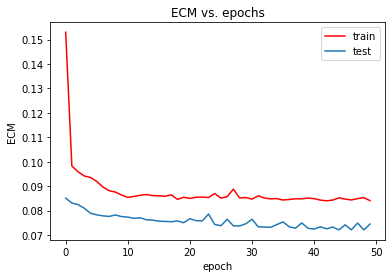

In [25]:
plt.plot(history.history['loss'],color = 'r',label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('epoch')
plt.ylabel('ECM')
plt.title('ECM vs. epochs')
plt.legend()

# Plot data test

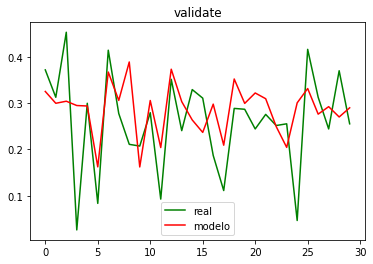

In [26]:
# hacemos una prediccion con test

results = modelo.predict(X_test)
plt.plot(range(len(y_test)),y_test,c='g',label='real')
plt.plot(range(len(results)),results,c='r', label = 'modelo')
plt.title('validate')
plt.legend(loc = 'best')
plt.show()

Pronóstico Ventas futuras

In [27]:
df.tail()

,unidades
fecha,
2018-11-26,276
2018-11-27,220
2018-11-28,183
2018-11-29,251
2018-11-30,189


In [28]:
# selecciono los últimos 16 dias
ultimos16Dias = df[-15:]
ultimos16Dias

,unidades
fecha,
2018-11-15,219
2018-11-16,152
2018-11-17,111
2018-11-19,207
2018-11-20,206
2018-11-21,183
2018-11-22,200
2018-11-23,187
2018-11-24,189


In [45]:
len(ultimos16Dias)

8

In [29]:
# escalados
ultimos16Dias = pd.DataFrame(scaler.fit_transform(ultimos16Dias))
ultimos16Dias.columns=['unidades']
ultimos16Dias

,unidades
0,0.715
1,0.380
2,0.175
3,0.655
4,0.650
5,0.535
6,0.620
7,0.555
8,0.565
9,0.000


In [30]:
ultimos16Dias['vf'] = ultimos16Dias['unidades'].shift(-1)
ultimos16Dias['vf2'] = ultimos16Dias['unidades'].shift(-2)
ultimos16Dias['vf3'] = ultimos16Dias['unidades'].shift(-3)
ultimos16Dias['vf4'] = ultimos16Dias['unidades'].shift(-4)
ultimos16Dias['vf5'] = ultimos16Dias['unidades'].shift(-5)
ultimos16Dias['vf6'] = ultimos16Dias['unidades'].shift(-6)
ultimos16Dias['vf7'] = ultimos16Dias['unidades'].shift(-7)
ultimos16Dias=ultimos16Dias.dropna()
ultimos16Dias.head()

,unidades,vf,vf2,vf3,vf4,vf5,vf6,vf7
0,0.715,0.380,0.175,0.655,0.650,0.535,0.620,0.555
1,0.380,0.175,0.655,0.650,0.535,0.620,0.555,0.565
2,0.175,0.655,0.650,0.535,0.620,0.555,0.565,0.000
3,0.655,0.650,0.535,0.620,0.555,0.565,0.000,1.000
4,0.650,0.535,0.620,0.555,0.565,0.000,1.000,0.720


In [31]:
# quitamos la ultima columna para predecirla
ld_train = ultimos16Dias.iloc[:,:-1]
ld_train

,unidades,vf,vf2,vf3,vf4,vf5,vf6
0,0.715,0.380,0.175,0.655,0.650,0.535,0.620
1,0.380,0.175,0.655,0.650,0.535,0.620,0.555
2,0.175,0.655,0.650,0.535,0.620,0.555,0.565
3,0.655,0.650,0.535,0.620,0.555,0.565,0.000
4,0.650,0.535,0.620,0.555,0.565,0.000,1.000
5,0.535,0.620,0.555,0.565,0.000,1.000,0.720
6,0.620,0.555,0.565,0.000,1.000,0.720,0.535
7,0.555,0.565,0.000,1.000,0.720,0.535,0.875


In [32]:
# seleccionamos la última fila (valor más actualizado)
X_test = ld_train.iloc[-1, :].values
X_test

array([0.555, 0.565, 0.   , 1.   , 0.72 , 0.535, 0.875])

In [33]:
# verificamos la forma de la data de entrenamiento
X_train.shape

(567, 7)

In [34]:
# verifico las dimensiones de la data test
X_test.shape

(7,)

In [35]:
# le damos la dimensión de la data con la que fue entrenado el modelo
X_test = X_test.reshape((1,X_test.shape[0]))
X_test.shape

(1, 7)

Función recursiva

In [36]:
# el parametro es el número de días a predecir con la última data ingresada

parametro = 7

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i] = x_test[0][i+1]
    x_test[0][x_test.shape[1]-1] = nuevoValor
    return x_test
 
results=[]
for i in range(parametro):
    parcial=modelo.predict(X_test)
    results.append(parcial[0])
    print(X_test)
    X_test=agregarNuevoValor(X_test,parcial[0])

[[0.555 0.565 0.    1.    0.72  0.535 0.875]]
[[0.565      0.         1.         0.72       0.535      0.875
  0.50355077]]
[[0.         1.         0.72       0.535      0.875      0.50355077
  0.27047828]]
[[1.         0.72       0.535      0.875      0.50355077 0.27047828
  0.63471812]]
[[0.72       0.535      0.875      0.50355077 0.27047828 0.63471812
  0.57995361]]
[[0.535      0.875      0.50355077 0.27047828 0.63471812 0.57995361
  0.49049354]]
[[0.875      0.50355077 0.27047828 0.63471812 0.57995361 0.49049354
  0.59089327]]


In [37]:
# convertimos la matriz en lista
adimen = [x for x in results]    

In [38]:
adimen

[array([0.50355077], dtype=float32),
 array([0.27047828], dtype=float32),
 array([0.6347181], dtype=float32),
 array([0.5799536], dtype=float32),
 array([0.49049354], dtype=float32),
 array([0.59089327], dtype=float32),
 array([0.4901845], dtype=float32)]

In [39]:
type(adimen)

list

In [40]:
# convertimos la lista en array
miarray = np.array(adimen)
miarray

array([[0.50355077],
       [0.27047828],
       [0.6347181 ],
       [0.5799536 ],
       [0.49049354],
       [0.59089327],
       [0.4901845 ]], dtype=float32)

In [41]:
# aplicamos escalamiento inverso para obtener los valores originales
inverted = scaler.inverse_transform(miarray)
inverted

array([[176.71016],
       [130.09566],
       [202.94363],
       [191.99072],
       [174.09871],
       [194.17865],
       [174.0369 ]], dtype=float32)

In [42]:
# ploteando el pronostico
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre

,pronostico
0,176.710159
1,130.095657
2,202.943634
3,191.990723
4,174.098709
5,194.178650
6,174.036896


In [43]:
total = pd.concat([df[-15:],prediccion1SemanaDiciembre], axis =0)
total

,unidades,pronostico
2018-11-15 00:00:00,219.0,NaN
2018-11-16 00:00:00,152.0,NaN
2018-11-17 00:00:00,111.0,NaN
2018-11-19 00:00:00,207.0,NaN
2018-11-20 00:00:00,206.0,NaN
2018-11-21 00:00:00,183.0,NaN
2018-11-22 00:00:00,200.0,NaN
2018-11-23 00:00:00,187.0,NaN
2018-11-24 00:00:00,189.0,NaN
2018-11-25 00:00:00,76.0,NaN


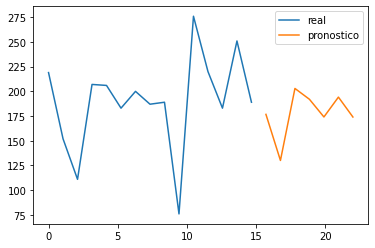

In [44]:
plt.plot(np.linspace(0,len(total),len(total)),total.unidades, label ='real')
plt.plot(np.linspace(0,len(total),len(total)),total.pronostico, label ='pronostico')
plt.legend(loc = 'best')